In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import sys
sys.path.append('..')
from utils.premium import suggested_premium
from utils.cleaning import create_age_groups
from utils.models import ml_model

In [2]:
# Save data to df
df = pd.read_stata('../data/h243.dta')
df.head()

,DUID,PID,DUPERSID,PANEL,DATAYEAR,FAMID31,FAMID42,FAMID53,FAMID22,FAMIDYR,...,RXOSR22,RXPTR22,RXOTH22,PERWT22F,FAMWT22F,FAMWT22C,SAQWT22F,DIABW22F,VARSTR,VARPSU
0,2460002,101,2460002101,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,0,0,5728.309495,5232.211986,5232.211986,3994.687140,6034.636755,2082,1
1,2460006,101,2460006101,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,0,0,15648.881461,16017.881691,16017.881691,0.000000,0.000000,2001,4
2,2460006,102,2460006102,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,0,0,14123.720178,16017.881691,12580.731740,0.000000,0.000000,2001,4
3,2460010,101,2460010101,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,5288,299,16982.054917,21905.758877,21905.758877,0.000000,0.000000,2038,3
4,2460018,101,2460018101,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,10,0,10682.619947,11344.291012,11344.291012,17152.439412,0.000000,2041,1


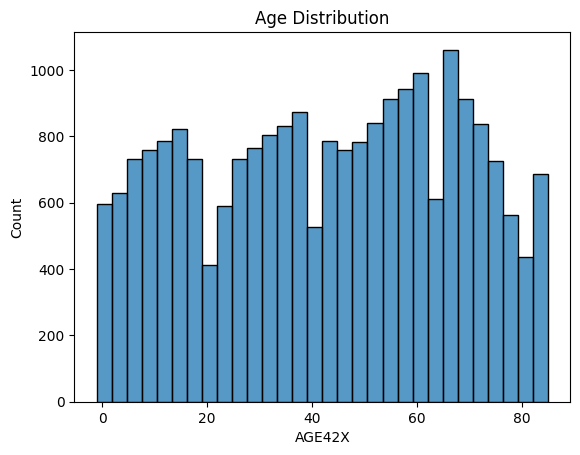

In [3]:
# The histogram shows a slight skew to the left, indicating more responses from older individuals.
age_fig = sns.histplot(
    x = 'AGE42X',
    data = df
).set_title('Age Distribution')

c:\Users\kevin\Modeling-Expected-Healthcare-Costs\notebooks\..\utils\cleaning.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['AGEGROUP'] = pd.cut(df['AGE42X'], bins = [0, 10, 20, 30, 40, 50, 60, 70, 100], labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+'])


Text(0.5, 1.0, 'Age Group Distribution')

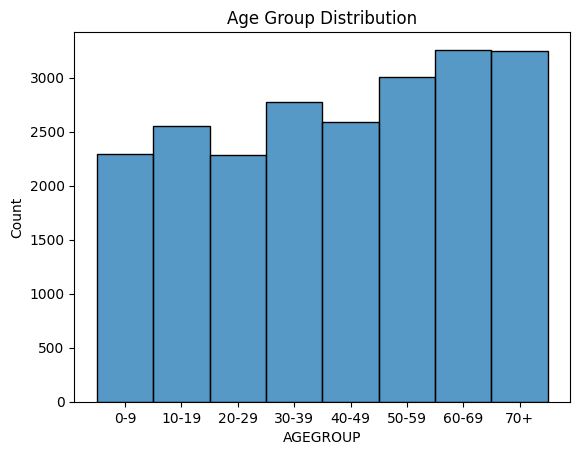

In [4]:
# Seperating ages into age groups shows a stronger left skewed distribution
create_age_groups(df)
sns.histplot(
    x ='AGEGROUP',
    data = df
).set_title('Age Group Distribution')

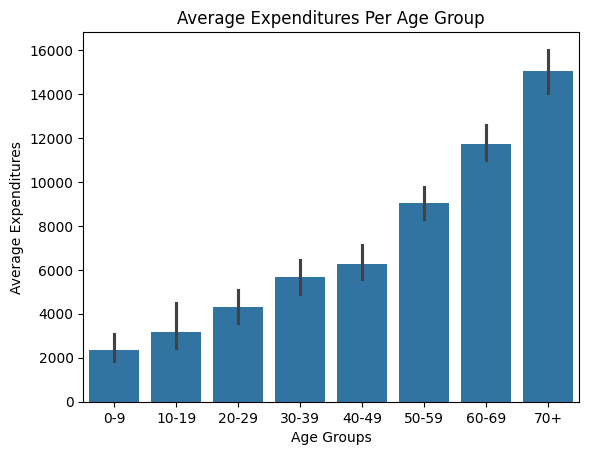

In [5]:
# The following bar plot visualizes how the older a person is, the 
age_expenditures = sns.barplot(
    x = df['AGEGROUP'],
    y = df['TOTEXP22']
).set(
    xlabel = 'Age Groups',
    ylabel = 'Average Expenditures',
    title = 'Average Expenditures Per Age Group'
)

In [7]:
# Create train test sets
# Predict total expenditures with age, gender, region, employment status, poverty percentage, and insurance coverage
model_df = df[['AGE42X', 'SEX', 'REGION42', 'EMPST42', 'POVCAT22', 'INSCOV22', 'TOTEXP22']].dropna()
x = model_df.drop(columns = 'TOTEXP22')
x = pd.get_dummies(x, columns=['SEX', 'REGION42', 'EMPST42', 'POVCAT22', 'INSCOV22'], drop_first=True)
y = model_df['TOTEXP22']

# Additionally created two seperate y_train and y_test sets, which will be used later in the second linear regression
# model. This is due to the heavily skewed nature of the data.
x_train, x_test, y_train, y_test, y_train_log, y_test_log = train_test_split(x, y, np.log1p(y), test_size = 0.2, random_state = 64)

In [8]:
# Using a linaer model gives a very low r squared value. This likely means that either
# the variables being used are low indicators of total expenditures or there is a non linear
# correlation between the variables.
linear_model = ml_model(LinearRegression(), x_train, x_test, y_train, y_test)

R Squared: 0.05245869451370477
r2_score 0.05245869451370477
mean_squared_error 422697650.13570213
mean_absolute_error 8619.474153210178


In [9]:
# By applying a log transformation using np.log1p(), the skew in the total expenditures can be reduced.
# This caused the R Squared value to drastically improve from 0.0525 to 0.2515, though the value is not
# large enough to determine a strong correlation.
linear_model_log = ml_model(LinearRegression(), x_train, x_test, y_train_log, y_test_log)

R Squared: 0.2514576529240118
r2_score 0.2514576529240118
mean_squared_error 7.711451675286367
mean_absolute_error 2.0738572192089886


In [10]:
# Create a random forest model of the data. This has a stronger r squared value than the first linear regression
# model, but it is slightly lower than the one with np.log1p.
rf_model = ml_model(RandomForestRegressor(n_estimators = 100, random_state = 64), x_train, x_test, y_train, y_test)

R Squared: -0.23483182008284964
r2_score -0.23483182008284964
mean_squared_error 550857789.1429579
mean_absolute_error 9606.829052334791


In [11]:
# Created a suggested premium for each individual based on many variables as shown below with a 70% loss ratio.
loss_ratio = 0.80
suggested_df = suggested_premium(rf_model, x, loss_ratio, model_df)
suggested_df.to_csv('../data/suggested_premiums.csv')
suggested_df.to_stata('../data/suggested_premiums.dta')
suggested_df.head()

,AGE42X,SEX,REGION42,EMPST42,POVCAT22,INSCOV22,TOTEXP22,predicted_cost,suggested_premium
0,77,2 FEMALE,2 MIDWEST,4 NOT EMPLOYED DURING RD 4/2,3 LOW INCOME,2 PUBLIC ONLY,15766,15267.833476,19084.79
1,63,2 FEMALE,2 MIDWEST,4 NOT EMPLOYED DURING RD 4/2,1 POOR/NEGATIVE,2 PUBLIC ONLY,12697,11143.446028,13929.31
2,67,1 MALE,2 MIDWEST,1 EMPLOYED AT RD 4/2 INT DATE,4 MIDDLE INCOME,2 PUBLIC ONLY,3405,6991.207639,8739.01
3,29,1 MALE,4 WEST,1 EMPLOYED AT RD 4/2 INT DATE,5 HIGH INCOME,1 ANY PRIVATE,9265,5384.183938,6730.23
4,51,2 FEMALE,1 NORTHEAST,1 EMPLOYED AT RD 4/2 INT DATE,4 MIDDLE INCOME,1 ANY PRIVATE,3362,4703.247548,5879.06
